In [5]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
19,12July_gpt2_10dim_12layer_256_RL,linear_regression,Transformer,,-1,-1,10,12,8,12July_gpt2_10dim_12layer_256_RL
21,12July_mlp_10dim_10layer_1024_RL,linear_regression,12July_mlp_10dim_10layer_1024_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_1024_RL
24,12July_mlp_10dim_10layer_512_RL,linear_regression,12July_mlp_10dim_10layer_512_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_512_RL
20,12July_mlp_10dim_22layer_1024_RL,linear_regression,12July_mlp_10dim_22layer_1024_RL,,-1,-1,10,22,8,12July_mlp_10dim_22layer_1024_RL
22,12July_mlp_10dim_5layer_1024_RL,linear_regression,12July_mlp_10dim_5layer_1024_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_1024_RL
23,12July_mlp_10dim_5layer_512_RL,linear_regression,12July_mlp_10dim_5layer_512_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_512_RL
26,24July_lstm_10dim_1layer_256_RL,linear_regression,24July_lstm_10dim_1layer_256_RL,,-1,-1,10,1,8,24July_lstm_10dim_1layer_256_RL
28,24July_lstm_10dim_5layer_256_RL,linear_regression,24July_lstm_10dim_5layer_256_RL,,-1,-1,10,5,8,24July_lstm_10dim_5layer_256_RL
25,24July_lstm_20dim_1layer_256_RL,linear_regression,24July_lstm_20dim_1layer_256_RL,,-1,-1,20,1,8,24July_lstm_20dim_1layer_256_RL
29,24July_lstm_20dim_5layer_256_RL,linear_regression,24July_lstm_20dim_5layer_256_RL,,-1,-1,20,5,8,24July_lstm_20dim_5layer_256_RL


In [7]:
"""
in our case, use linear regression
"""

task = "linear_regression" 
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

"""
Replace run_id
"""
run_id = "6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1 6Aug_lstm_20dim_9layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 85019.68it/s]

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9825033187866211, 0.9316158294677734, 0.8673872947692871, 0.904058837890625, 0.8271295547485351, 0.7440825462341308, 0.8002631187438964, 0.7052121639251709, 0.6794011116027832, 0.6670123100280761, 0.6067232608795166, 0.5971486091613769, 0.5150001525878907, 0.514289379119873, 0.5221220970153808, 0.5039319038391114, 0.47636938095092773, 0.4580071449279785, 0.4092715263366699, 0.4119718074798584, 0.37021071910858155, 0.3338038921356201, 0.3393144130706787, 0.3139058589935303, 0.30968127250671384, 0.3084076404571533, 0.28187730312347414, 0.3022501468658447, 0.2696461915969849, 0.2632270097732544, 0.2324413537979126, 0.2254253625869751, 0.22741169929504396, 0.21993160247802734, 0.20227575302124023, 0.1760660767555237, 0.17638524770736694, 0.17679637670516968, 0.1797170400619507, 0.1659608840942383, 0.15882800817489623], 'std': [1.501460361480713, 1.3640807151794434, 1.295315551757

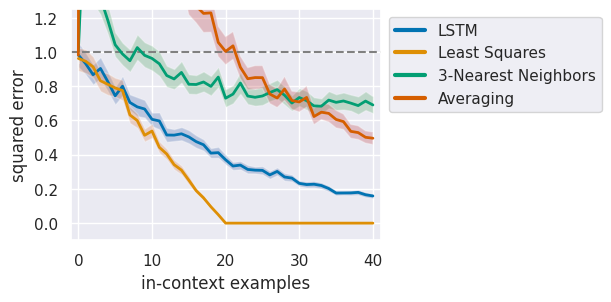

In [8]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0209195137023925, 0.9378484725952149, 0.8481341361999511, 0.8401384353637695, 0.681469202041626, 0.6164427757263183, 0.5676535606384278, 0.4674086093902588, 0.4703518867492676, 0.4089874267578125, 0.3485404491424561, 0.3286778211593628, 0.29063191413879397, 0.2657121181488037, 0.23780462741851807, 0.22112905979156494, 0.2020735502243042, 0.19721755981445313, 0.1754728674888611, 0.16004396677017213, 0.13853012323379515, 0.1336199164390564, 0.11741900444030762, 0.10693223476409912, 0.10177398920059204, 0.10325100421905517, 0.08507631421089172, 0.08404449224472046, 0.07412427067756652, 0.07010202407836914, 0.06082892417907715, 0.06661120057106018, 0.059970510005950925, 0.05472455620765686, 0.04814803600311279, 0.04776180386543274, 0.04573462605476379, 0.0407860666513443, 0.042238110303878786, 0.04072298407554627, 0.03683374524116516], 'std': [1.5278612136840821, 1.51899528503417

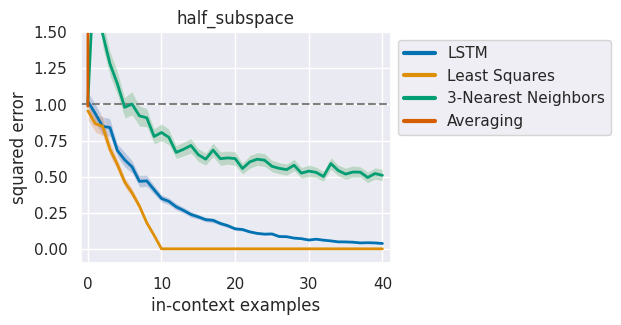

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.005204677581787, 0.9307044982910156, 0.9377346038818359, 0.9228273391723633, 0.8279699325561524, 0.8045994758605957, 0.75312180519104, 0.7519547462463378, 0.6902333259582519, 0.6319203853607178, 0.6617188453674316, 0.6010160923004151, 0.5692548274993896, 0.5676525592803955, 0.593524694442749, 0.5234360694885254, 0.49250059127807616, 0.4915360927581787, 0.46745824813842773, 0.4590432167053223, 0.4408563613891602, 0.40961766242980957, 0.44116506576538084, 0.40171060562133787, 0.35479183197021485, 0.38304734230041504, 0.36580615043640136, 0.3432324886322021, 0.3273162841796875, 0.3146411180496216, 0.31976919174194335, 0.3026787042617798, 0.2979511499404907, 0.2713287353515625, 0.27883248329162597, 0.2783393859863281, 0.25147571563720705, 0.25483317375183107, 0.24188714027404784, 0.2538542985916138, 0.23972680568695068], 'std': [1.4402935028076171, 1.4286087989807128, 1.420771598

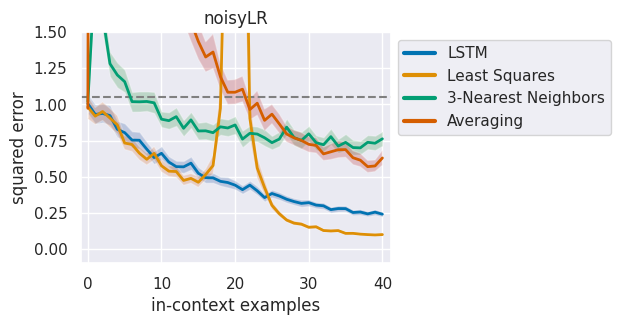

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.006291389465332, 0.9720980644226074, 1.0352927207946778, 0.963687515258789, 0.9954380989074707, 0.9995211601257324, 0.9756240844726562, 1.07814359664917, 0.9946981430053711, 0.9536483764648438, 0.9851592063903809, 1.0254297256469727, 1.0609870910644532, 0.9798652648925781, 1.029324436187744, 1.0057111740112306, 1.0165470123291016, 1.0657278060913087, 0.9383296966552734, 1.0718660354614258, 0.0008470108732581139, 0.000892813690006733, 0.0008955652825534344, 0.0009651674889028072, 0.0009555904194712639, 0.000994870625436306, 0.001001777406781912, 0.0009755978360772132, 0.0009692547842860222, 0.0010042810812592507, 0.0009934281930327415, 0.0009956926107406617, 0.0010434562340378762, 0.0010328361764550208, 0.0010251471772789954, 0.0010147914290428162, 0.0010578234679996968, 0.0010713106021285057, 0.0010315438732504845, 0.0010322695598006248, 0.0011245348490774632], 'std': [1.5371

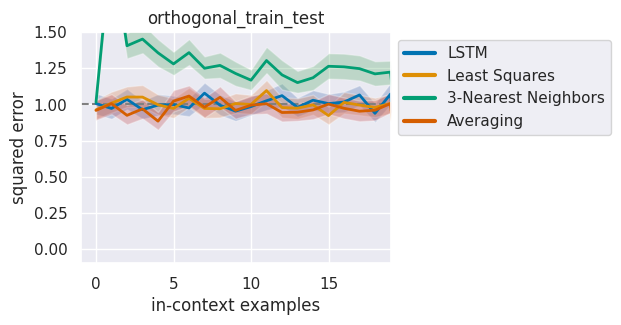

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9953191757202149, 0.04022890627384186, 0.03745443224906921, 0.04798249304294586, 0.055463796854019164, 0.07043864727020263, 0.07039161324501038, 0.09071550369262696, 0.09072595834732056, 0.09088469743728637, 0.10201437473297119, 0.10066006183624268, 0.10440044403076172, 0.10289928913116456, 0.1130776047706604, 0.1260074257850647, 0.12201979160308837, 0.13221542835235595, 0.11545321941375733, 0.11455190181732178, 0.11445069313049316, 0.11296446323394775, 0.11878979206085205, 0.11484472751617432, 0.10212939977645874, 0.10866634845733643, 0.1080823302268982, 0.10238463878631592, 0.10222699642181396, 0.10568399429321289, 0.10037200450897217, 0.09757474064826965, 0.10414766073226929, 0.08900755047798156, 0.09218205213546753, 0.08955878019332886, 0.0863864243030548, 0.08277202844619751, 0.07935330867767335, 0.0755767822265625, 0.08159343600273132], 'std': [1.4400022506713868, 0.088

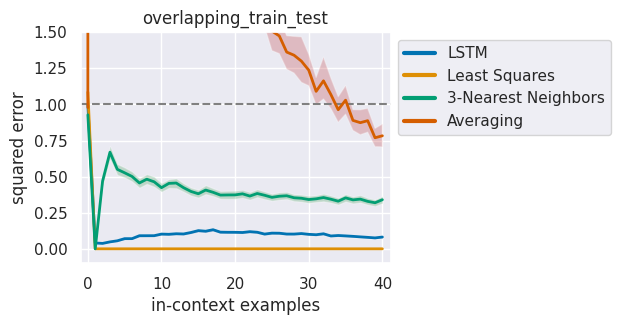

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0504892349243165, 0.9048027038574219, 1.0009246826171876, 0.8522367477416992, 0.8877970695495605, 0.8754286766052246, 0.8784612655639649, 0.7917922973632813, 0.7987430572509766, 0.7802382469177246, 0.7505002498626709, 0.7193662166595459, 0.6705775260925293, 0.7206477165222168, 0.6989854335784912, 0.7284586906433106, 0.6243348598480225, 0.6274149894714356, 0.5994786739349365, 0.6029976367950439, 0.5371243476867675, 0.523429012298584, 0.5630919456481933, 0.6058732509613037, 0.5421526908874512, 0.5229220867156983, 0.5044062614440918, 0.5004488945007324, 0.537141990661621, 0.5028756618499756, 0.5007851600646973, 0.45205392837524416, 0.4413645267486572, 0.4331852912902832, 0.43598089218139646, 0.5080015182495117, 0.4205235481262207, 0.43651304244995115, 0.42191343307495116, 0.4470394134521484, 0.3940335750579834], 'std': [1.4959508895874023, 1.316655158996582, 1.6158504486083984, 

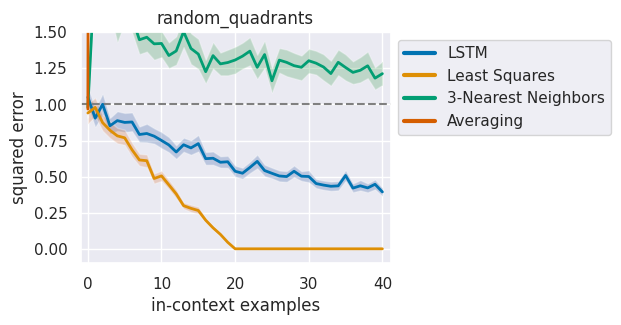

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.10716748237609863, 0.10491735935211181, 0.1162100076675415, 0.1005638599395752, 0.1068834662437439, 0.10146796703338623, 0.10393877029418945, 0.09392479062080383, 0.08574486970901489, 0.08277961015701293, 0.08334074020385743, 0.08834355473518371, 0.07746311426162719, 0.0804188072681427, 0.07588328123092651, 0.0728880763053894, 0.07617281079292297, 0.06860524415969849, 0.07334235906600953, 0.0687996804714203, 0.06978515386581421, 0.06640197038650512, 0.061143559217453, 0.06549595594406128, 0.05684000253677368, 0.05803343653678894, 0.05924524068832397, 0.05798768997192383, 0.05075051784515381, 0.058042114973068236, 0.05196820497512818, 0.0516352653503418, 0.05325716733932495, 0.05018876194953918, 0.050765717029571535, 0.05185063481330872, 0.04876699447631836, 0.04646793901920319, 0.0496960461139679, 0.047485795617103574, 0.04501353800296783], 'std': [0.15532319545745848, 0.1611

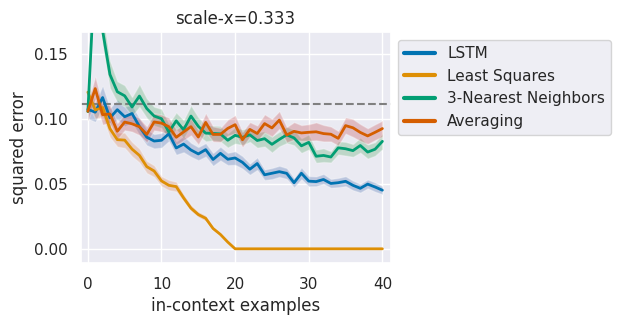

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.24509086608886718, 0.24243850708007814, 0.23222217559814454, 0.2307145595550537, 0.22165043354034425, 0.2017463207244873, 0.21448254585266113, 0.18619493246078492, 0.18779491186141967, 0.1743714690208435, 0.16512806415557862, 0.15513386726379394, 0.15455321073532105, 0.1368991494178772, 0.13978030681610107, 0.14175193309783934, 0.13138923645019532, 0.12508599758148192, 0.12095706462860108, 0.11174266338348389, 0.11144453287124634, 0.10895665884017944, 0.10464918613433838, 0.09876221418380737, 0.10263118743896485, 0.09290549159049988, 0.0863098919391632, 0.08364837765693664, 0.08840970993041992, 0.08077512979507447, 0.07824231386184692, 0.07431671619415284, 0.07283394932746887, 0.0717379868030548, 0.0683334469795227, 0.061909472942352294, 0.06433389186859131, 0.060526835918426516, 0.06032097339630127, 0.06086057424545288, 0.05614427328109741], 'std': [0.37641568183898927, 0.36

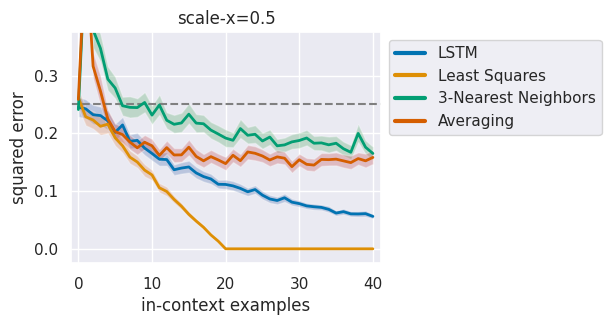

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [4.003958892822266, 3.585076904296875, 3.5080097198486326, 3.5906909942626952, 3.5057037353515623, 2.7766239166259767, 2.9989955902099608, 2.8244043350219727, 2.8535242080688477, 2.9228458404541016, 2.97705020904541, 2.692222023010254, 2.5498849868774416, 2.4370975494384766, 2.2670175552368166, 2.2794353485107424, 2.1152013778686523, 2.079159736633301, 2.1081350326538084, 1.8658830642700195, 1.8284551620483398, 1.7539606094360352, 1.7354303359985352, 1.7615795135498047, 1.63046875, 1.7152542114257812, 1.6445613861083985, 1.6760873794555664, 1.5733538627624513, 1.4569691658020019, 1.4505961418151856, 1.3672882080078126, 1.4292007446289063, 1.2965856552124024, 1.3279546737670898, 1.2662111282348634, 1.2530731201171874, 1.0684844970703125, 1.2156255722045899, 1.1635148048400878, 1.1325379371643067], 'std': [5.700154113769531, 5.321540069580078, 5.3480979919433596, 5.475663757324218

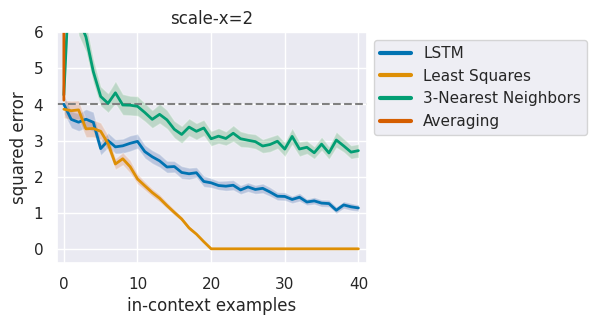

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [9.461196136474609, 8.848453521728516, 8.131120300292968, 8.265616607666015, 7.986080169677734, 7.802927398681641, 7.827060699462891, 7.213738250732422, 7.404307556152344, 6.434992980957031, 6.976213073730468, 6.426908874511719, 6.404240417480469, 6.140431976318359, 6.084108352661133, 6.250311279296875, 5.978279876708984, 5.605980300903321, 5.835348510742188, 5.362111282348633, 5.219281005859375, 5.091812515258789, 4.912221145629883, 4.631743240356445, 5.52857551574707, 4.763944244384765, 5.012246704101562, 4.69937744140625, 5.012229919433594, 4.732526397705078, 4.464448547363281, 4.679118347167969, 5.067446899414063, 4.415395736694336, 4.294996643066407, 4.4122367858886715, 4.212134552001953, 4.712470245361328, 4.5809173583984375, 4.382191467285156, 4.177978515625], 'std': [13.678785705566407, 13.554048156738281, 11.836883544921875, 12.582160949707031, 11.45618896484375, 11.814

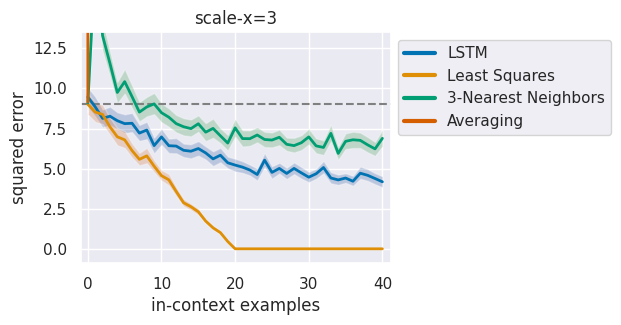

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.11156941652297973, 0.11003446578979492, 0.10813615322113038, 0.09538284540176392, 0.09031095504760742, 0.08907753825187684, 0.08032935261726379, 0.08242780566215516, 0.07708948850631714, 0.07160414457321167, 0.06832979917526245, 0.06437576413154603, 0.06952793598175049, 0.06375212669372558, 0.0606099009513855, 0.055295854806900024, 0.05384548902511597, 0.05245572328567505, 0.0491165965795517, 0.04519683718681335, 0.04827693998813629, 0.04570964276790619, 0.041014629602432254, 0.037753328680992126, 0.041364654898643494, 0.036302116513252256, 0.03504902720451355, 0.03488687574863434, 0.03252589702606201, 0.03142805993556976, 0.0312586098909378, 0.029202115535736085, 0.028946322202682496, 0.02907087206840515, 0.030699938535690308, 0.024851909279823302, 0.024761116504669188, 0.025529512763023378, 0.023290061950683595, 0.02477189004421234, 0.023403224349021912], 'std': [0.16441171

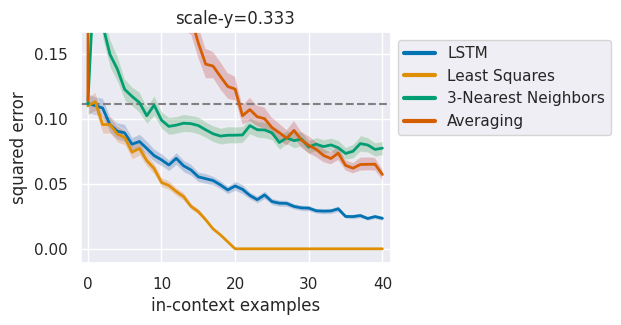

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.2680922031402588, 0.2262706995010376, 0.21704387664794922, 0.21097073554992676, 0.21658709049224853, 0.19244234561920165, 0.17697864770889282, 0.1764828085899353, 0.16426658630371094, 0.1699972152709961, 0.14844565391540526, 0.14079221487045288, 0.13522679805755616, 0.13394851684570314, 0.1342458486557007, 0.1284371256828308, 0.11949752569198609, 0.10648988485336304, 0.10266619920730591, 0.10362565517425537, 0.09321573376655579, 0.09682915806770324, 0.08695845603942871, 0.07921963930130005, 0.08085428476333618, 0.07810603976249694, 0.0737523078918457, 0.07429221272468567, 0.07085109949111938, 0.06953800320625306, 0.06090360283851624, 0.061834019422531125, 0.05289071798324585, 0.055595004558563234, 0.056848388910293576, 0.05719789266586304, 0.050412428379058835, 0.04962761998176575, 0.045503169298172, 0.04717077314853668, 0.0460202157497406], 'std': [0.38724920749664304, 0.320

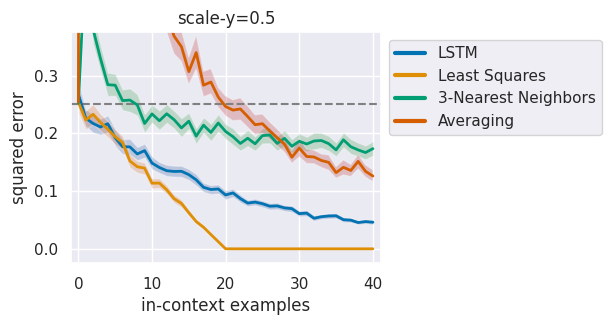

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [3.8311195373535156, 3.6940753936767576, 3.700756072998047, 3.618206024169922, 3.104034423828125, 3.152622032165527, 3.2331493377685545, 2.8037979125976564, 2.983791542053223, 2.5275247573852537, 2.450898361206055, 2.497273063659668, 2.5483877182006838, 2.272562789916992, 2.2913610458374025, 1.9857891082763672, 2.023636245727539, 1.7880701065063476, 1.8834665298461915, 1.787791633605957, 1.7080350875854493, 1.6431455612182617, 1.5515960693359374, 1.4916770935058594, 1.5561826705932618, 1.4537243843078613, 1.340613555908203, 1.4072941780090331, 1.2784093856811523, 1.2024205207824707, 1.2801373481750489, 1.218306541442871, 1.120448112487793, 1.1829164505004883, 1.050496768951416, 0.994468879699707, 0.9515987396240234, 1.068006706237793, 0.9586655616760253, 0.8631221771240234, 0.9808046340942382], 'std': [5.880364990234375, 5.642935180664063, 5.762118911743164, 5.671102905273438, 4

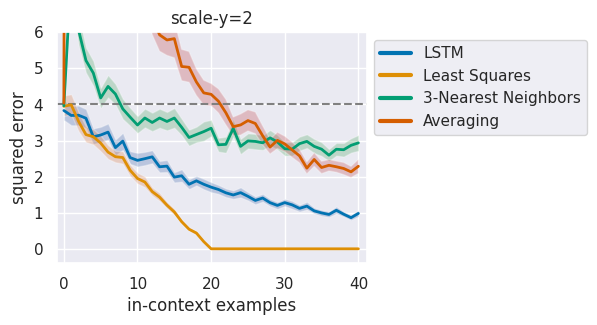

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [8.543556213378906, 8.919666290283203, 7.967806243896485, 8.011070251464844, 7.687161254882812, 7.678867340087891, 7.386679840087891, 7.294917297363281, 6.836647033691406, 6.6530006408691404, 6.891227722167969, 6.038066864013672, 5.934772491455078, 5.431052780151367, 5.7738899230957035, 5.3409374237060545, 5.365538787841797, 5.2171588897705075, 5.3339683532714846, 5.36981430053711, 5.179362106323242, 5.202732086181641, 4.6371620178222654, 4.941211700439453, 4.582813262939453, 4.644381713867188, 4.670856094360351, 4.352640914916992, 4.42352180480957, 4.48419075012207, 4.470336151123047, 4.597980117797851, 4.309822845458984, 3.98419075012207, 4.328692245483398, 4.079298782348633, 4.070167160034179, 4.055753326416015, 3.89135856628418, 3.941754913330078, 4.0260967254638675], 'std': [13.200619506835938, 13.431149291992188, 12.555591583251953, 12.050860595703124, 11.383061981201172, 

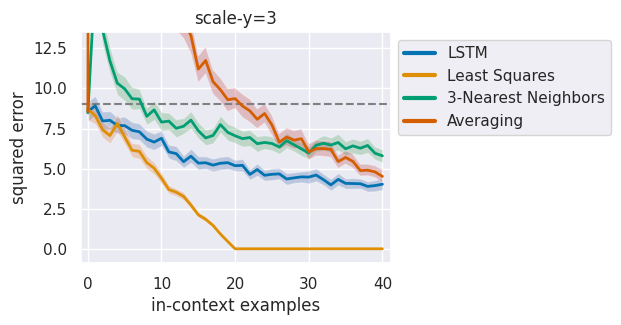

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0555810928344727, 0.6867928981781006, 0.5557278156280517, 0.44163265228271487, 0.3608067274093628, 0.3396399974822998, 0.30476348400115966, 0.3019314527511597, 0.2914870738983154, 0.27264795303344724, 0.2610501766204834, 0.22885448932647706, 0.2143174648284912, 0.20662589073181153, 0.20669751167297362, 0.19553468227386475, 0.1949628472328186, 0.20319657325744628, 0.18989166021347045, 0.19070065021514893, 0.18091156482696533, 0.1682094931602478, 0.16171724796295167, 0.16117286682128906, 0.14295649528503418, 0.1426715612411499, 0.16496585607528685, 0.1339529871940613, 0.14949182271957398, 0.17513644695281982, 0.15069315433502198, 0.1469269037246704, 0.13595123291015626, 0.1289775252342224, 0.13059960603713988, 0.1292189598083496, 0.13148031234741211, 0.13499265909194946, 0.13449151515960694, 0.13199666738510132, 0.1301877021789551], 'std': [2.425983428955078, 1.4664059638977052

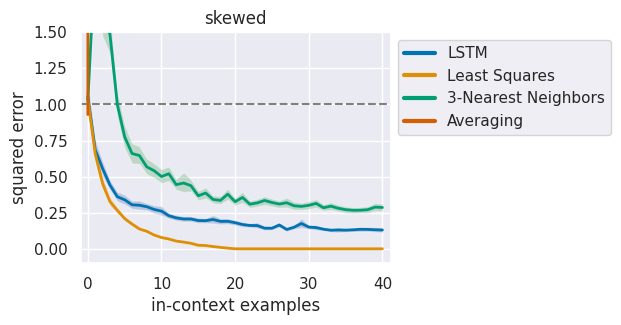

In [9]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [10]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [11]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

self.wpe: Embedding(101, 256)


In [12]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [13]:
with torch.no_grad():

    pred = model(xs, ys)

IndexError: index out of range in self

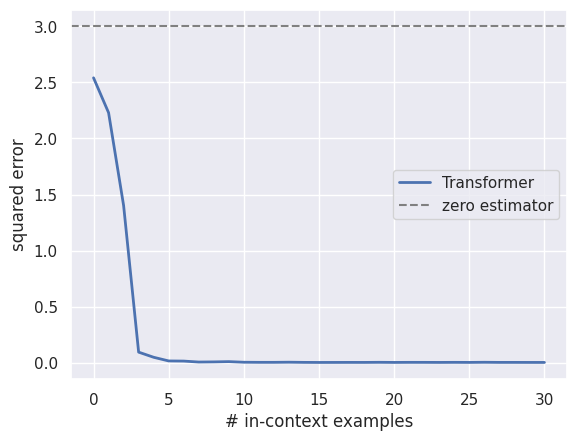

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

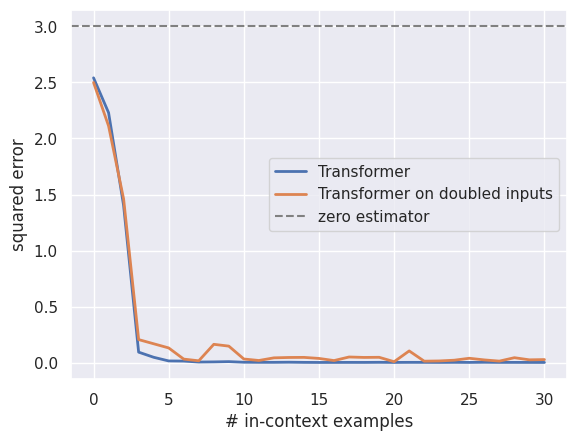

In [ ]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.